## Machine Learning - Assignment 1
Submitted by S Deepak Narayanan, 16110142, B.Tech (CSE)

In [1]:
import numpy as np 
import pandas as pd
from math import log
from sklearn.model_selection import train_test_split

### Q2 (a) Discrete Feature Discrete Output Decision Tree for Classification
Note - Please rename output variable to be 'Class' in your dataset for this implementation to work

In [2]:
def entropy(target):
    freq = {}
    for elem in target:
        if elem not in freq:
            freq[elem]=1/len(target)
        else: 
            freq[elem]+=1/len(target)
    _sum = [-freq[i]*np.log2(freq[i]) for i in freq]
    return sum(_sum)

def info_gain(data,attributes):
    entropy_dataset = entropy(data['Class'])
    entr_val = {}
    infg = {}
    for attr in attributes:
        freq = {}
        for i in data[attr]:
            if i not in freq:
                freq[i]=1/len(data[attr])
            else:
                freq[i]+=1/len(data[attr])
        keys = list(freq.keys())
        entr = {}
        for i in keys:
            temp = len(data[data[attr]==i])
            entr[i] = temp/len(data)*entropy(data[data[attr]==i]['Class'])
        entr_val[attr] = sum(list(entr.values()))
        infg[attr] = entropy_dataset - entr_val[attr]
    return max(infg, key = infg.get)

def dtree(dataset,data,attributes,parent):
    
    attribute = [i for i in attributes]
    
    if len(data['Class'].unique())<=1:
        return (list(data['Class'].unique())[0])
    elif len(data)==0:
        return np.unique(data['Class'])[np.argmax(np.unique(data['Class'],return_counts=True)[1])]
    elif len(attribute)==0:
        return parent
    else:
        parent = np.unique(data['Class'])[np.argmax(np.unique(data['Class'],return_counts=True)[1])]
        
    best = info_gain(data,attribute)
    tree = {best:{}}
    attribute.remove(best)
    for ndata in data[best].unique():
        new_data = data[data[best]==ndata]
        subtree = dtree(dataset,new_data,attribute,parent)
        tree[best][ndata]=subtree
    return tree  

### Sample Prediction of Tennis Dataset using the above code

In [3]:
dt = pd.read_csv('tennis.csv')
dt = dt.drop(['Day'],axis = 1)
attrb = list(dt.columns)
attrb.remove('Class')
dt

,outlook,temp,humidity,windy,Class
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


In [4]:
dtree(dt,dt,attrb,None)

{'outlook': {'Sunny': {'humidity': {'High': 'No', 'Normal': 'Yes'}},
  'Overcast': 'Yes',
  'Rain': {'windy': {'Weak': 'Yes', 'Strong': 'No'}}}}

### Q2 (a) continued

In [5]:
df = pd.read_csv('iris.csv')
arr = np.array(df)
df.head(10)

def class_aggregate(dataset):
    temp = []
    for i in range(len(dataset)):
        temp.append(dataset[i][-1])
    temp = np.unique(np.array(temp))
    return temp

cls = class_aggregate(np.array(df))

def val_replace(cls,dataset):
    for i in range(len(cls)):
        dataset = dataset.replace(cls[i],i)
    return dataset

df = val_replace(cls,df)

### Q2 (a)  Continuous Features Discrete Output Decision Tree for Classification


In [6]:
## Iris Dataset Classification
def gini(splits,classes):
    total_rows = 0
    final = 0
    for i in range(len(splits)):
        total_rows+=len(splits[i])
    final = 0
    for split in splits:
        if len(split)==0:
            continue
        gscore = 0
        for cls in classes:
            p = [row[-1] for row in split].count(cls)/len(split)
            gscore+=p*p
        final+= (1-gscore)*(len(split)/total_rows)
    return final
## This needs to be done very carefully
## Binary Splits
def divide_data(dataset,feature,threshold):
    new_data1 = []
    new_data2 = []
    for elem in dataset:
        if elem[feature]<threshold:
            new_data1.append(elem)
        else:
            new_data2.append(elem)
    return new_data1, new_data2

def best_split(dataset,classes):
    best_so_far = np.inf
    best_splits = 0
    feature = np.inf
    value_split = 1000
    for i in range(len(dataset[0])-1):
        for elem in dataset:
            splits = divide_data(dataset,i,elem[i])
            gscore = gini(splits,classes)
            if gscore<best_so_far:
                best_so_far = gscore
                best_splits = splits
                feature = i
                value_split = elem[i]
    return {'split':best_splits,'Feature':feature,'Value':value_split}


def leaf_node(split):
    cls = [elem[-1] for elem in split]
    # Take Majority Vote
    count = {}
    for i in cls:
        if i not in count:
            count[i]=1
        else:
            count[i]+=1
    return max(count, key = count.get)

def partition(node, maxdepth, minsize, depth):
    ## Each partition from above gives a node in essence.
    lchild, rchild = node['split']
    if not lchild or not rchild:
        node['left']= leaf_node(lchild+rchild)
        node['right'] = leaf_node(lchild+rchild)
        return
    if depth>maxdepth:
        node['left'] = leaf_node(lchild)
        node['right'] = leaf_node(rchild)
        return
    if len(lchild)<=minsize:
        node['left'] = leaf_node(lchild)
    else:
        node['left'] = best_split(lchild,cls)
        partition(node['left'],maxdepth,minsize, depth+1)
    if len(rchild)<=minsize:
        node['right'] = leaf_node(rchild)
    else:
        node['right'] = best_split(rchild,cls)
        partition(node['right'],maxdepth,minsize,depth+1)
        

def tree_iris(dataset, maxdepth, minsize):
    root = best_split(dataset,cls)
    partition(root,maxdepth,minsize,1)
    ## Printing the made Decision Tree
    return root

def predict(node, row):
    if row[node['Feature']] < node['Value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

def class_aggregate(dataset):
    temp = []
    for i in range(len(dataset)):
        temp.append(dataset[i][-1])
    temp = np.unique(np.array(temp))
    return temp

cls = class_aggregate(np.array(df))

def val_replace(cls,dataset):
    for i in range(len(cls)):
        dataset = dataset.replace(cls[i],i)
    return dataset

df = val_replace(cls,df)

def accurate(test,tree):
    temp = 0
    for i in test:
        val = predict(tree,i)
        if i[-1]==val:
            temp+=1
    return temp/len(test)*100

### Q2 (b) with accuracy below
Note: I have kept minimum number of samples to 0; This means we try to split even when we have only one data sample.

Also the first part is without shuffling - we get an accuracy of 73.33 percent for a tree depth of 2.

In [7]:
train = np.array(df)[:105]
test = np.array(df)[105:]
tree_cls = tree_iris(train,2,0)
accurate(test,tree_cls)

73.33333333333333

### Q2 (c) 5 Fold Cross Validation below
Note - I have implemented without shuffling. 

In [8]:
def kfold_cross_validation(dataset):
    for i in range(5):
        test = dataset[30*i:30*(i+1)]
        if 30*(i+1)+120<=150:
            train = dataset[30*(i+1):]
        else:
            train1 = dataset[0:30*(i+1)-30]
            train2 = dataset[30*(i+1):]
            train = np.append(train1,train2,axis=0)
        tree = tree_iris(train,4,0)
        print(accurate(test,tree))

In [9]:
kfold_cross_validation(np.array(df))

100.0
96.66666666666667
83.33333333333334
90.0
76.66666666666667


The average cross validation accuracy is 88.664 %

### Q2(c) Nested Cross Validation 

In [10]:
def nested_cross_validation(dataset):
    for i in range(5):
        test = dataset[30*i:30*(i+1)]
        if 30*(i+1)+120<=150:
            train = dataset[30*(i+1):]
        else:
            train1 = dataset[0:30*(i+1)-30]
            train2 = dataset[30*(i+1):]
            train = np.append(train1,train2,axis=0)
        accuracy_validation = {}
        for depth in range(1,11):
            s = 0
            for j in range(4):
                validation = train[30*j:30*(j+1)]
                train_1 = train[30*(j+1):]
                train_2 = train[0:30*(j+1)-30]
                train_ = np.append(train_1,train_2,axis = 0)
                tree = tree_iris(train_,depth,0)
                s+=(accurate(validation,tree))
            accuracy_validation[depth] = s/4
        value = max(accuracy_validation, key = accuracy_validation.get)
        tree = tree_iris(train,value,0)
        print("Accuracy is,",accurate(test,tree), " for iteration",i+1, ". The depth of the optimal tree is ",value)
nested_cross_validation(np.array(df))

Accuracy is, 100.0  for iteration 1 . The depth of the optimal tree is  1
Accuracy is, 100.0  for iteration 2 . The depth of the optimal tree is  1
Accuracy is, 83.33333333333334  for iteration 3 . The depth of the optimal tree is  2
Accuracy is, 90.0  for iteration 4 . The depth of the optimal tree is  1
Accuracy is, 83.33333333333334  for iteration 5 . The depth of the optimal tree is  1


* The average accuracy after performing nested cross-validation is, 91.334 %.
* As we can see from above, the optimal depth is somewhere in between 1 and 2, as it gives the highest accuracy on the validation data for each held out test set.

### Q4 
#### Comparing Scikit-Learn Tree and Custom Implementation

In [11]:
## Classification Task
from sklearn import tree
temp = np.array(df)
X = []
y = []
for i in range(len(temp)):
    X.append(temp[i][:4])
    y.append(temp[i][-1])
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train,y_train)
## Accuracy Part
count = 0
predicted = clf.predict(X_test)
for i in range(len(predicted)):
    if predicted[i]==y_test[i]:
        count+=1
print(count/len(X_test)*100, "percent accuracy is obtained using in-built scikit learn implementation.")
print("91.334 % is the average accuracy obtained using cross validation")

97.36842105263158 percent accuracy is obtained using in-built scikit learn implementation.
91.334 % is the average accuracy obtained using cross validation


### Q3 Continuous Regression using Decision Tree
* Kindly rename the value of the to be predicted value as y.
* Also, the dataset fed into all the functions is a Pandas DataFrame

In [12]:
def reducestd(data,attributes):
    var = {}
    for attr in attributes:
        freq = {}
        for i in data[attr]:
            if i not in freq:
                freq[i]=1/len(data[attr])
            else:
                freq[i]+=1/len(data[attr])
        keys = list(freq.keys())
        st = 0
        for i in keys:
            temp = (data[data[attr]==i])
            st+=np.std(temp['y'])*len(temp)/len(data)
        var[attr]=st
    return min(var,key = var.get)

def dtreereg(dataset,data,attributes,min_examples,parent):
    """
        If we don't simply have enough training data, 
        we do this. 
    """
    if len(data)<=min_examples:
        return data['y'].mean()
    elif len(data)==0:
        return dataset['y'].mean()
    elif len(attributes)==0:
        return parent
    else:
        parent = data['y'].mean()
        best = reducestd(data,attributes)
        tree = {best:{}}
        attributes.remove(best)
        subtree_basis = [i for i in data[best].unique()]
        for nnode in subtree_basis:
            new_data = data.where(data[best]==nnode).dropna()
            subtree = dtreereg(dataset,new_data,attributes, min_examples,parent)
            tree[best][nnode] = subtree
    return tree

def regressor_predict(tree,instance):
    for index in tree.keys():
        if index in instance:
            try:
                potential = tree[index][instance[index]]
            except:
                return df_reg['y'].mean()
            potential =tree[index][instance[index]]  # Avoid referencement error
            if type(potential) == dict:
                return regressor_predict(potential, instance)
            else:
                return potential

In [13]:
df_reg = pd.read_excel('realestate.xlsx')
df_reg = df_reg.drop(['No'],axis = 1)
df_reg.head()
df_reg = df_reg.dropna()
attb = list(df_reg.columns)
attb.remove('y')

In [14]:
train, test = train_test_split(df_reg,test_size = 0.3, random_state = 42)

In [15]:
tree_reg = dtreereg(train,train,attb,4,None)

In [16]:
err = np.zeros(len(test))
y_pred = np.zeros(len(test))
for i in range(len(test)):
    val = regressor_predict(tree_reg,test.iloc[i])
    y_pred[i] = val
    err[i] = test.iloc[i]['y'] - val

#### Two Metrics have been used for this example. 
These include 
1. RMSE
2. Absolute Mean Error


In [17]:
## RMSE
print("RMSE",((err**2).mean())**0.5)
## RMSE Standard Deviatiot
print("RMSE - STDDEV",((err**2).std())**0.5)
## MAE
temp = np.sum(np.abs(err))/len(err)
print("MAE",temp)
## MAE STDDEV
temp = np.abs(err).std()
print("MAE STDDEV",temp)

RMSE 10.324941104363576
RMSE - STDDEV 13.25090872729112
MAE 7.62896745398927
MAE STDDEV 6.957245460277299


### Q4 Comparison of MAE

In [18]:
### Regression Task - Scikit Learn
from sklearn.metrics import mean_absolute_error
reg =  tree.DecisionTreeRegressor()
columns = list(df_reg.columns)
columns.remove('y')
X = df_reg[columns]
y = df_reg['y']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33,random_state = 42)
reg.fit(X_train,y_train)
pred = reg.predict(X_test)
print("MAE and STDDEV are ",mean_absolute_error(pred, y_test), np.std(np.abs(pred-y_test)))

MAE and STDDEV are  5.981021897810219 5.9842345533327395


### Q5 
#### Below is the classifier learnt on IRIS Dataset by Scikit - Learn.
#### Following that is the Decision Tree that the model implemented created. The code is directly taken from [here](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/), from where I had based my above implementation too.

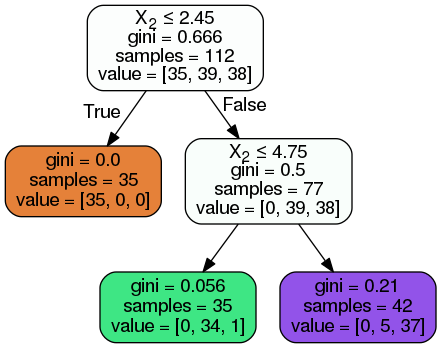

In [19]:
### INBUILT Classification
from sklearn.tree import export_graphviz
from IPython.display import Image  
from io import StringIO
import pydot
dot_data = StringIO()  
export_graphviz(clf, out_file=dot_data,  
                       
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  [0]
Image(graph.create_png())


In [20]:
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['Feature']+1), node['Value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
print_tree(tree_cls)

[X3 < 3.000]
 [X1 < 5.100]
  [X1 < 4.900]
  [X1 < 5.100]
 [X3 < 5.100]
  [X1 < 7.000]
  [X4 < 1.800]


## Q7

### The theoretical running time is O(mnlogn), where n is the number of samples and m is the number of features

In [21]:
mn_learn = []
mn_test = []

In [22]:
import random
import string
import time

I stopped the below execution intermittently. The Results are plotted below. This was because it was taking really long and I couldn't run any other processes concurrently. I am attaching a small sample and plots below.

In [23]:
mnl = []
mnt = []
for m in range(2,10):
    print(m)
    for n in range(100,120):
        df_mn = pd.DataFrame(np.random.randn(n, m))
        start_time  = time.time()
        attb = list(df_mn.columns)
#         print(attb)
        tmp = max(attb)
        attb.remove(tmp)
        attb.append('y')
#         print(attb)
        df_mn.columns = attb
#         print(df_mn.columns)
        attb.remove('y')
        train, test = train_test_split(df_mn,test_size = 0.33,random_state=42)
        start_time = time.time()
        _ = dtreereg(train,train,attb,4,None)
        mnl.append(time.time() - start_time)
        start_time  = time.time()
        for i in range(len(test)):
            val = test.iloc[i]
            regressor_predict(_,instance=val)
        mnt.append(time.time() - start_time)

2
3
4
5
6
7
8
9


Text(0.5, 1.0, ' M varied from 2 to 10, N from 100 to 120 - Time vs # of times trained and tested')

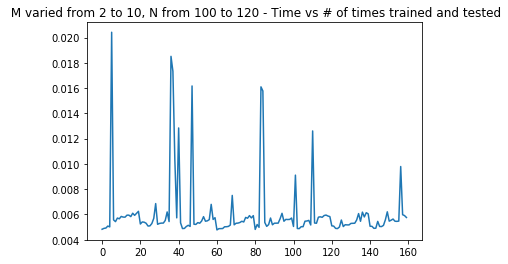

In [28]:
import matplotlib.pyplot as plt
plt.plot(mnt)
plt.title(' M varied from 2 to 10, N from 100 to 120 - Time vs # of times trained and tested')

Text(0.5, 1.0, ' M varied from 2 to 10, N from 100 to 120 - Time vs # of times trained and tested')

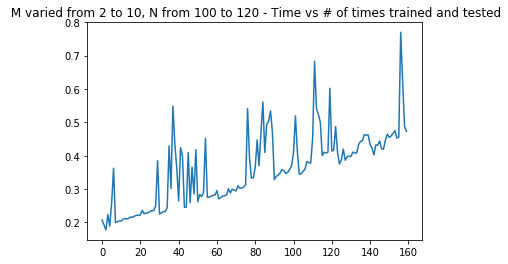

In [29]:
plt.plot(mnl)
plt.title(' M varied from 2 to 10, N from 100 to 120 - Time vs # of times trained and tested')

### As we can see an increasing trend with a few non linearities in the above two plots.

Text(0, 0.5, 'Time in seconds for training')

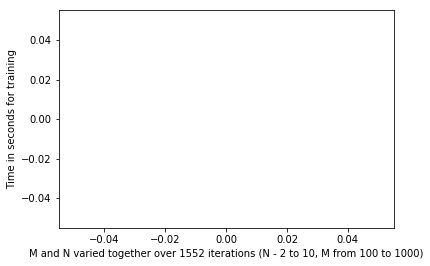

In [30]:
plt.plot([i for i in range(len(mn_learn))],[i for i in mn_learn])
plt.xlabel('M and N varied together over 1552 iterations (N - 2 to 10, M from 100 to 1000)')
plt.ylabel('Time in seconds for training')

Text(0.5, 1.0, 'DT as used for the housing price problem')

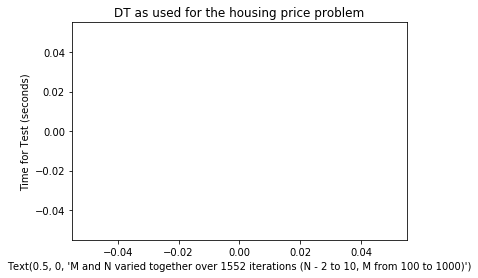

In [31]:
plt.plot([i for i in range(len(mn_test))],[i for i in mn_test])
plt.xlabel(plt.xlabel('M and N varied together over 1552 iterations (N - 2 to 10, M from 100 to 1000)'))
plt.ylabel('Time for Test (seconds)')
plt.title('DT as used for the housing price problem')

Theoretically, we should expect an almost linear increase as it grows as O(mnlogn), where m is number of features and n is the number of samples. This is because logn grows slower than any polynomial in n.

## Q6

In [32]:
### Working on the IRIS Data Problem
df = pd.read_csv('iris.csv')
arr = np.array(df)
df.head(10)
cls = class_aggregate(np.array(df))
df = val_replace(cls,df)
new = np.array(df)
df.head()

,c1,c2,c3,c4,Class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [33]:
train,test = train_test_split(new,test_size = 0.3)

In [34]:
import matplotlib.pyplot as plt

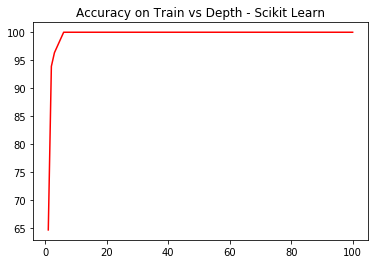

In [35]:
temp = np.array(df)
X = []
y = []
for i in range(len(temp)):
    X.append(temp[i][:4])
    y.append(temp[i][-1])
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42,test_size = 0.45)
orders = {}
for i1 in range(1,101):
    clf = tree.DecisionTreeClassifier(max_depth=i1)
    clf = clf.fit(X_train,y_train)
    ## Accuracy Part
    count = 0
    predicted = clf.predict(X_train)
    for i in range(len(predicted)):
        if predicted[i]==y_train[i]:
            count+=1
    orders[i1] = count/len(X_train)*100
plt.title('Accuracy on Train vs Depth - Scikit Learn')
plt.plot(orders.keys(), orders.values(),c = 'r')

##### Best Predictor Accuracy

In [36]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf.fit(X_train,y_train)
pred_best = clf.predict(X_test)
count = 0
for i in range(len(pred_best)):
    if pred_best[i]==y_test[i]:
        count+=1
print(count/len(pred_best)*100)

98.52941176470588


##### Worst predictor on train data with accuracy

In [37]:
clf = tree.DecisionTreeClassifier(max_depth=1)
clf.fit(X_train,y_train)
pred_worst = clf.predict(X_test)
count = 0
for i in range(len(pred_best)):
    if pred_worst[i]==y_test[i]:
        count+=1
print(count/len(pred_worst)*100)

69.11764705882352


#### Worst performance on train data - Only one split - Depth = 1; Best - any split more than 4, as per Scikit Learn

#### Self implementation - best accuracy for depth is below

In [38]:
train, test = train_test_split(np.array(df),test_size = 0.45,random_state = 42)
tree_cls = tree_iris(train,2,0)
accurate(test,tree_cls)

30.88235294117647